In [1]:
%run tools.ipynb

In [2]:
# crop yield data 2x2.5
fname = '../data/crop/crop_yield_2x2.5.nc'
ds_yield = xr.open_dataset(fname) 
#ds_yield
selected_crops = ['maize_major', 'maize_second', 'rice_major', 'rice_second', 
                  'wheat_spring', 'wheat_winter', 'soybean']
# create yield mask for slicing data
ds_yield_mask = ds_yield.copy()
for icrop in selected_crops: 
    da = ds_yield[icrop]
    daa = xr.where(da > 0, 1., 0.)
    ds_yield_mask[icrop] = daa.copy()

In [3]:
#ds_yield

In [4]:
# harvest date
fname = '../data/crop/crop_calendar_2x2.5.nc'
ds_harvest = xr.open_dataset(fname) # ds_harvest['maize_second'] empty
#ds_harvest

In [5]:
# ozone data
fname = '../data/ozone/moch/GCHP.localtime.nc'
#fname = '../data/ozone/moch/geoE.localtime.nc'
ds_ozone = xr.open_dataset(fname)
ds_ozone

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 144, time: 8784)
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
    lev      float64 ...
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 89.5
  * time     (time) datetime64[ns] 2016-01-01T00:30:00 ... 2016-12-31T23:30:00
Data variables:
    ozone    (time, lat, lon) float32 ...
Attributes:
    comment:  local time ozone concentration

In [6]:
ozone_hourly = ds_ozone['ozone'] # 2x2.5 resolution
nhours = len(ozone_hourly.time.values)
ozone_hourly
ds_ozone

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 144, time: 8784)
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
    lev      float64 ...
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 89.5
  * time     (time) datetime64[ns] 2016-01-01T00:30:00 ... 2016-12-31T23:30:00
Data variables:
    ozone    (time, lat, lon) float32 ...
Attributes:
    comment:  local time ozone concentration

In [7]:
# ozone metrics initialization
dr_m12 = ozone_hourly[:len(selected_crops), :, :]
dr_m12 = dr_m12.drop_vars('lev') # drop lev coordinate
dr_m12 = dr_m12.rename({'time': 'crop'})
dr_m12['crop'] = range(len(selected_crops))
dr_m12['crop'].attrs['comment'] = selected_crops

dr_m12[:,:,:] = np.nan
dr_m7 = dr_m12.copy()
dr_aot40 = dr_m12.copy()
dr_m12

<xarray.DataArray 'ozone' (crop: 7, lat: 91, lon: 144)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 89.5
  * crop     (crop) int64 0 1 2 3 4 5 6

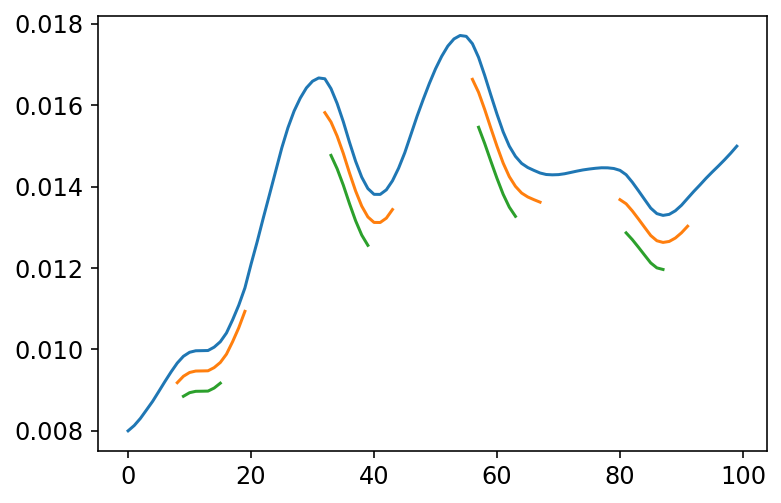

In [8]:
# 8:00 to 20:00 local time, for M12 and AOT40
temporal_mask_m12 = np.tile([0.]*8 + [1.]*12 + [0.]*4, int(nhours/24))
# 9:00 to 16:00
temporal_mask_m7 = np.tile([0.]*9 + [1.]*7 + [0.]*8, int(nhours/24))

# testing the hourly mask
plt.plot(ozone_hourly.values[:100,30,10] * 1e6)
ozone_masked = np.transpose(ozone_hourly.values, (1, 2, 0)) * temporal_mask_m12 *1e6 # unit: ppm
ozone_masked_12h = xr.where(ozone_masked > 0, ozone_masked, np.nan)
plt.plot(ozone_masked_12h[30,10,:100]*0.95)
ozone_masked_7h = ozone_masked_12h * temporal_mask_m7
ozone_masked_7h = xr.where(ozone_masked_7h > 0, ozone_masked_7h, np.nan)
plt.plot(ozone_masked_7h[30,10,:100]*0.9)


In [9]:
for i, icrop in enumerate(selected_crops):
    
    # temporal mask, crop calendar, 104 days - 14 days before harvest
    harvest = ds_harvest[icrop]
    yield_mask = ds_yield_mask[icrop]
    tmp = harvest * yield_mask
    harvest_mask = xr.where(tmp > 0, tmp, np.nan)

    # get begin and end of impact hours
    impact_hours_end = (harvest_mask-14) * 24
    impact_hours_begin = (harvest_mask-104) * 24
    
    
    for ilat in range(len(dr_m12.lat.values)):
        for ilon in range(len(dr_m12.lon.values)):
            if impact_hours_end[ilat, ilon].values > 0:
                begin = int(impact_hours_begin[ilat, ilon].values)
                end = int(impact_hours_end[ilat, ilon].values)

                dr_m12[i,ilat, ilon] = np.nanmean(ozone_masked_12h[ilat,ilon, begin:end]) * 1e3
                
                tmp = ozone_masked_12h[ilat,ilon, begin:end] - 0.04
                tmp1 = np.where(tmp < 0, 0., tmp)
                dr_aot40[i,ilat, ilon] = np.nansum(tmp1)

                dr_m7[i,ilat, ilon] = np.nanmean(ozone_masked_7h[ilat,ilon, begin:end]) * 1e3


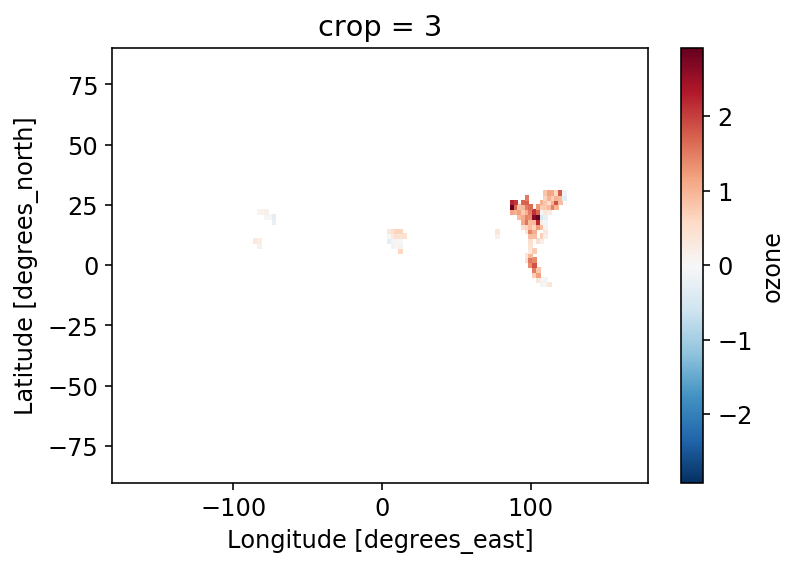

In [10]:
#dr_m12.plot()
diff = dr_m7 - dr_m12
diff[3,:,:].plot()

In [11]:

ds_metrics = dr_m12.to_dataset(name = 'm12')
ds_metrics['m7'] = dr_m7
ds_metrics['aot40'] = dr_aot40

ds_metrics.to_netcdf('../data/geoE_ozone_metrics.nc')